In [1]:
import torch
import torchvision
from torch.utils.data import dataloader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

In [2]:
n_epochs=100
batch_size_train=400
batch_size_test=1000
log_interval=1
random_seed=6
torch.manual_seed(random_seed)
learning_rate = 0.01
momentum=0.5

In [3]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/',train=True,download=True,transform=torchvision.transforms.Compose([torchvision.transforms.RandomAffine(degrees = 0,translate=(0.1, 0.1)),
                                   torchvision.transforms.RandomRotation((-10,10)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,),(0.3081,))#,torchvision.transforms.Resize([96,96])
    ])),batch_size=batch_size_train,shuffle=True)
test_loader=test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             #,torchvision.transforms.Resize([96,96])
                             ])),
  batch_size=batch_size_test, shuffle=True)


In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

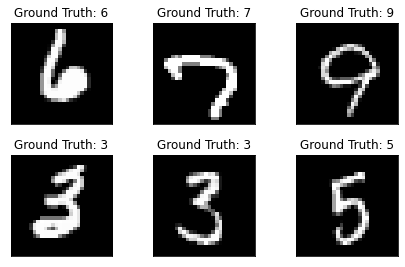

In [5]:
fig = plt.figure()
for i in range(6):
      plt.subplot(2,3,i+1)
      plt.tight_layout()
      plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
      plt.title("Ground Truth: {}".format(example_targets[i]))
      plt.xticks([])
      plt.yticks([])
plt.show()

In [6]:
#model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Convolution layer 1 (（w - f + 2 * p）/ s ) + 1
        self.conv1 = nn.Conv2d(in_channels = 1 , out_channels = 32, kernel_size = 5, stride = 1, padding = 0 )
        self.relu1 = nn.ReLU()
        self.batch1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(in_channels =32 , out_channels = 64, kernel_size = 3, stride = 1, padding = 0 )
        self.relu2 = nn.ReLU()
        self.batch2 = nn.BatchNorm2d(64)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv1_drop = nn.Dropout(0.25)

        # Convolution layer 2
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 0 )
        self.relu3 = nn.ReLU()
        self.batch3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1, padding = 0 )
        self.relu4 = nn.ReLU()
        self.batch4 = nn.BatchNorm2d(256)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2_drop = nn.Dropout(0.25)

        # Fully-Connected layer 1
        
        self.fc1 = nn.Linear(2304,512)
        self.fc1_relu = nn.ReLU()
        self.dp1 = nn.Dropout(0.3)
        
        # Fully-Connected layer 2
        self.fc2 = nn.Linear(512,10)
                
    def forward(self, x):
        # conv layer 1 的前向计算，3行代码
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.batch1(out)
        #out = self.conv1_drop(out)
        
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.batch2(out)
        
        out = self.maxpool1(out)
        out = self.conv1_drop(out)

        # conv layer 2 的前向计算，4行代码
        out = self.conv3(out)
        out = self.relu3(out)
        out = self.batch3(out)
        
        out = self.conv4(out)
        out = self.relu4(out)
        out = self.batch4(out)
        
        out = self.maxpool2(out)
        out = self.conv2_drop(out)

        #Flatten拉平操作
        out = out.view(out.size(0),-1)

        #FC layer的前向计算（2行代码）
        out = self.fc1(out)
        out = self.fc1_relu(out)
        out = self.dp1(out)
        
        out = self.fc2(out)

        return F.log_softmax(out,dim = 1)



In [7]:
network = Net()

In [8]:

     
device=torch.device('cuda:0'if torch.cuda.is_available()else 'cpu')

network.to(device)


Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1_drop): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (relu3): ReLU()
  (batch3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (relu4): ReLU()
  (batch4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_drop): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=2304, o

In [9]:
# 设置优化器，用stochastic gradient descent，设置学习率，设置momentum
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
#optimizer = optim.Adam(network.parameters(), lr=learning_rate)
#optimizer = optim.RMSprop(network.parameters(),lr=learning_rate,alpha=0.99,momentum = momentum)
#设置学习率梯度下降，如果连续三个epoch测试准确率没有上升，则降低学习率
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True, threshold=0.00005, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)





In [10]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [11]:
def train(epoch):
      #network=
      network.to(device)
      network.train()
      
      for batch_idx, (data, target) in enumerate(train_loader):
            data=data.to(device)
            target=target.to(device)
            optimizer.zero_grad()
            output = network(data)
            #output.to(device)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % (log_interval) == 0:
                  print('\r Train Epoch: {} [{}/{} ({:.2f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()),end='')
                  train_losses.append(loss.item())
                  train_counter.append(
                    (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
                  torch.save(network.state_dict(), './model.pth')

In [12]:
def test():
  #network=network.to(device)
  network.eval()
  network.to(device)
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      
      data=data.to(device)
      target=target.to(device)
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))


In [13]:
#network_state=torch.load("./model.pth")
#network.load_state_dict(network_state)
#optimizer_state_dict = torch.load('./optimizer.pth')
#optimizer.load_state_dict(optimizer_state_dict)
for i in range(0,n_epochs):      
      test_counter.append(i*len(train_loader.dataset))
      train(i)
      test()
      torch.save(optimizer.state_dict(), './optimizer.pth')
      

 Train Epoch: 0 [59600/60000 (99.33%)]	Loss: 0.339131

/home/sad/anaconda3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0963, Accuracy: 9760/10000 (97.60%)

 Train Epoch: 1 [59600/60000 (99.33%)]	Loss: 0.173006
Test set: Avg. loss: 0.0577, Accuracy: 9841/10000 (98.41%)

 Train Epoch: 2 [59600/60000 (99.33%)]	Loss: 0.151643
Test set: Avg. loss: 0.0456, Accuracy: 9878/10000 (98.78%)

 Train Epoch: 3 [59600/60000 (99.33%)]	Loss: 0.153224
Test set: Avg. loss: 0.0362, Accuracy: 9906/10000 (99.06%)

 Train Epoch: 4 [59600/60000 (99.33%)]	Loss: 0.104037
Test set: Avg. loss: 0.0343, Accuracy: 9889/10000 (98.89%)

 Train Epoch: 5 [59600/60000 (99.33%)]	Loss: 0.109279
Test set: Avg. loss: 0.0332, Accuracy: 9901/10000 (99.01%)

 Train Epoch: 6 [59600/60000 (99.33%)]	Loss: 0.112317
Test set: Avg. loss: 0.0278, Accuracy: 9916/10000 (99.16%)

 Train Epoch: 7 [59600/60000 (99.33%)]	Loss: 0.048843
Test set: Avg. loss: 0.0259, Accuracy: 9927/10000 (99.27%)

 Train Epoch: 8 [59600/60000 (99.33%)]	Loss: 0.085935
Test set: Avg. loss: 0.0274, Accuracy: 9923/10000 (99.23%)

 Train Epoch: 9 [59600/6000

 Train Epoch: 72 [59600/60000 (99.33%)]	Loss: 0.044482
Test set: Avg. loss: 0.0115, Accuracy: 9965/10000 (99.65%)

 Train Epoch: 73 [59600/60000 (99.33%)]	Loss: 0.031560
Test set: Avg. loss: 0.0118, Accuracy: 9962/10000 (99.62%)

 Train Epoch: 74 [59600/60000 (99.33%)]	Loss: 0.038981
Test set: Avg. loss: 0.0111, Accuracy: 9965/10000 (99.65%)

 Train Epoch: 75 [59600/60000 (99.33%)]	Loss: 0.031664
Test set: Avg. loss: 0.0116, Accuracy: 9955/10000 (99.55%)

 Train Epoch: 76 [59600/60000 (99.33%)]	Loss: 0.028519
Test set: Avg. loss: 0.0115, Accuracy: 9962/10000 (99.62%)

 Train Epoch: 77 [59600/60000 (99.33%)]	Loss: 0.035424
Test set: Avg. loss: 0.0111, Accuracy: 9965/10000 (99.65%)

 Train Epoch: 78 [59600/60000 (99.33%)]	Loss: 0.023906
Test set: Avg. loss: 0.0104, Accuracy: 9965/10000 (99.65%)

 Train Epoch: 79 [59600/60000 (99.33%)]	Loss: 0.028247
Test set: Avg. loss: 0.0115, Accuracy: 9963/10000 (99.63%)

 Train Epoch: 80 [59600/60000 (99.33%)]	Loss: 0.020557
Test set: Avg. loss: 0.01

In [14]:
for i in range(100,120):      
      test_counter.append(i*len(train_loader.dataset))
      train(i)
      test()
      torch.save(optimizer.state_dict(), './optimizer.pth')

 Train Epoch: 100 [59600/60000 (99.33%)]	Loss: 0.015309
Test set: Avg. loss: 0.0104, Accuracy: 9967/10000 (99.67%)

 Train Epoch: 101 [59600/60000 (99.33%)]	Loss: 0.017536
Test set: Avg. loss: 0.0110, Accuracy: 9967/10000 (99.67%)

 Train Epoch: 102 [59600/60000 (99.33%)]	Loss: 0.019220
Test set: Avg. loss: 0.0107, Accuracy: 9968/10000 (99.68%)

 Train Epoch: 103 [59600/60000 (99.33%)]	Loss: 0.035966
Test set: Avg. loss: 0.0105, Accuracy: 9966/10000 (99.66%)

 Train Epoch: 104 [59600/60000 (99.33%)]	Loss: 0.016364
Test set: Avg. loss: 0.0108, Accuracy: 9965/10000 (99.65%)

 Train Epoch: 105 [59600/60000 (99.33%)]	Loss: 0.050716
Test set: Avg. loss: 0.0116, Accuracy: 9964/10000 (99.64%)

 Train Epoch: 106 [59600/60000 (99.33%)]	Loss: 0.007303
Test set: Avg. loss: 0.0107, Accuracy: 9966/10000 (99.66%)

 Train Epoch: 107 [59600/60000 (99.33%)]	Loss: 0.020629
Test set: Avg. loss: 0.0108, Accuracy: 9966/10000 (99.66%)

 Train Epoch: 108 [59600/60000 (99.33%)]	Loss: 0.010061
Test set: Avg. l

In [15]:
for i in range(120,130):      
      test_counter.append(i*len(train_loader.dataset))
      train(i)
      test()
      torch.save(optimizer.state_dict(), './optimizer.pth')

 Train Epoch: 120 [59600/60000 (99.33%)]	Loss: 0.031876
Test set: Avg. loss: 0.0098, Accuracy: 9970/10000 (99.70%)

 Train Epoch: 121 [59600/60000 (99.33%)]	Loss: 0.023167
Test set: Avg. loss: 0.0099, Accuracy: 9967/10000 (99.67%)

 Train Epoch: 122 [59600/60000 (99.33%)]	Loss: 0.005925
Test set: Avg. loss: 0.0103, Accuracy: 9964/10000 (99.64%)

 Train Epoch: 123 [59600/60000 (99.33%)]	Loss: 0.008222
Test set: Avg. loss: 0.0105, Accuracy: 9968/10000 (99.68%)

 Train Epoch: 124 [59600/60000 (99.33%)]	Loss: 0.005937
Test set: Avg. loss: 0.0097, Accuracy: 9970/10000 (99.70%)

 Train Epoch: 125 [59600/60000 (99.33%)]	Loss: 0.019698
Test set: Avg. loss: 0.0099, Accuracy: 9969/10000 (99.69%)

 Train Epoch: 126 [59600/60000 (99.33%)]	Loss: 0.014289
Test set: Avg. loss: 0.0100, Accuracy: 9972/10000 (99.72%)

 Train Epoch: 127 [59600/60000 (99.33%)]	Loss: 0.012819
Test set: Avg. loss: 0.0095, Accuracy: 9969/10000 (99.69%)

 Train Epoch: 128 [59600/60000 (99.33%)]	Loss: 0.018236
Test set: Avg. l

In [16]:
for i in range(130,150):      
      test_counter.append(i*len(train_loader.dataset))
      train(i)
      test()
      torch.save(optimizer.state_dict(), './optimizer.pth')

 Train Epoch: 130 [59600/60000 (99.33%)]	Loss: 0.016577
Test set: Avg. loss: 0.0100, Accuracy: 9969/10000 (99.69%)

 Train Epoch: 131 [59600/60000 (99.33%)]	Loss: 0.020877
Test set: Avg. loss: 0.0100, Accuracy: 9966/10000 (99.66%)

 Train Epoch: 132 [59600/60000 (99.33%)]	Loss: 0.009208
Test set: Avg. loss: 0.0101, Accuracy: 9966/10000 (99.66%)

 Train Epoch: 133 [59600/60000 (99.33%)]	Loss: 0.010583
Test set: Avg. loss: 0.0106, Accuracy: 9969/10000 (99.69%)

 Train Epoch: 134 [59600/60000 (99.33%)]	Loss: 0.015352
Test set: Avg. loss: 0.0104, Accuracy: 9965/10000 (99.65%)

 Train Epoch: 135 [59600/60000 (99.33%)]	Loss: 0.006803
Test set: Avg. loss: 0.0102, Accuracy: 9969/10000 (99.69%)

 Train Epoch: 136 [59600/60000 (99.33%)]	Loss: 0.012507
Test set: Avg. loss: 0.0092, Accuracy: 9972/10000 (99.72%)

 Train Epoch: 137 [59600/60000 (99.33%)]	Loss: 0.016771
Test set: Avg. loss: 0.0099, Accuracy: 9970/10000 (99.70%)

 Train Epoch: 138 [59600/60000 (99.33%)]	Loss: 0.019832
Test set: Avg. l

In [17]:
for i in range(150,170):      
      test_counter.append(i*len(train_loader.dataset))
      train(i)
      test()
      torch.save(optimizer.state_dict(), './optimizer.pth')

 Train Epoch: 150 [59600/60000 (99.33%)]	Loss: 0.029319
Test set: Avg. loss: 0.0100, Accuracy: 9970/10000 (99.70%)

 Train Epoch: 151 [59600/60000 (99.33%)]	Loss: 0.010298
Test set: Avg. loss: 0.0099, Accuracy: 9964/10000 (99.64%)

 Train Epoch: 152 [59600/60000 (99.33%)]	Loss: 0.013698
Test set: Avg. loss: 0.0096, Accuracy: 9972/10000 (99.72%)

 Train Epoch: 153 [59600/60000 (99.33%)]	Loss: 0.012595
Test set: Avg. loss: 0.0097, Accuracy: 9971/10000 (99.71%)

 Train Epoch: 154 [59600/60000 (99.33%)]	Loss: 0.018754
Test set: Avg. loss: 0.0101, Accuracy: 9971/10000 (99.71%)

 Train Epoch: 155 [59600/60000 (99.33%)]	Loss: 0.021121
Test set: Avg. loss: 0.0105, Accuracy: 9968/10000 (99.68%)

 Train Epoch: 156 [59600/60000 (99.33%)]	Loss: 0.010302
Test set: Avg. loss: 0.0098, Accuracy: 9972/10000 (99.72%)

 Train Epoch: 157 [59600/60000 (99.33%)]	Loss: 0.004508
Test set: Avg. loss: 0.0103, Accuracy: 9970/10000 (99.70%)

 Train Epoch: 158 [59600/60000 (99.33%)]	Loss: 0.042210
Test set: Avg. l

In [18]:
for i in range(170,200):      
      test_counter.append(i*len(train_loader.dataset))
      train(i)
      test()
      torch.save(optimizer.state_dict(), './optimizer.pth')

 Train Epoch: 170 [59600/60000 (99.33%)]	Loss: 0.018366
Test set: Avg. loss: 0.0093, Accuracy: 9974/10000 (99.74%)

 Train Epoch: 171 [59600/60000 (99.33%)]	Loss: 0.011411
Test set: Avg. loss: 0.0098, Accuracy: 9971/10000 (99.71%)

 Train Epoch: 172 [59600/60000 (99.33%)]	Loss: 0.017258
Test set: Avg. loss: 0.0102, Accuracy: 9973/10000 (99.73%)

 Train Epoch: 173 [59600/60000 (99.33%)]	Loss: 0.026713
Test set: Avg. loss: 0.0096, Accuracy: 9971/10000 (99.71%)

 Train Epoch: 174 [59600/60000 (99.33%)]	Loss: 0.011810
Test set: Avg. loss: 0.0101, Accuracy: 9970/10000 (99.70%)

 Train Epoch: 175 [59600/60000 (99.33%)]	Loss: 0.019943
Test set: Avg. loss: 0.0103, Accuracy: 9966/10000 (99.66%)

 Train Epoch: 176 [59600/60000 (99.33%)]	Loss: 0.039365
Test set: Avg. loss: 0.0103, Accuracy: 9971/10000 (99.71%)

 Train Epoch: 177 [59600/60000 (99.33%)]	Loss: 0.012365
Test set: Avg. loss: 0.0098, Accuracy: 9966/10000 (99.66%)

 Train Epoch: 178 [59600/60000 (99.33%)]	Loss: 0.034894
Test set: Avg. l